In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1900

nband = 1100

nv = 200

dv = 0.005

tsfc =294

ng =5

nref =2

p_refs = (/ 1 , 50 /) 

t_refs = (/ 250 , 250 /) 

ng_refs = (/ 3 , 2 /) 

data wgt
     &     /0.7 , 0.6 , 0.6 , 0.7,
     &     0.9/

option_wgt_flux =2

option_wgt_k =1

option_klin =1

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66/

klin =6.5e-24

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

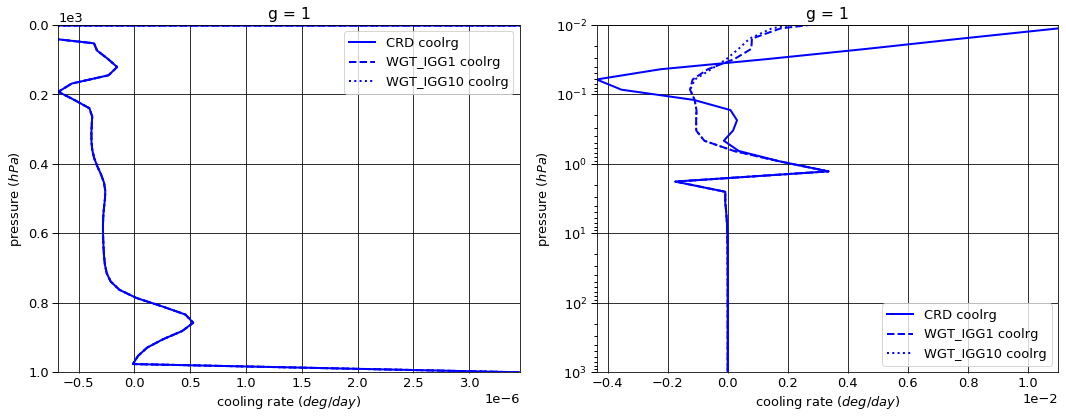

# Figure: cooling rate g-group 2

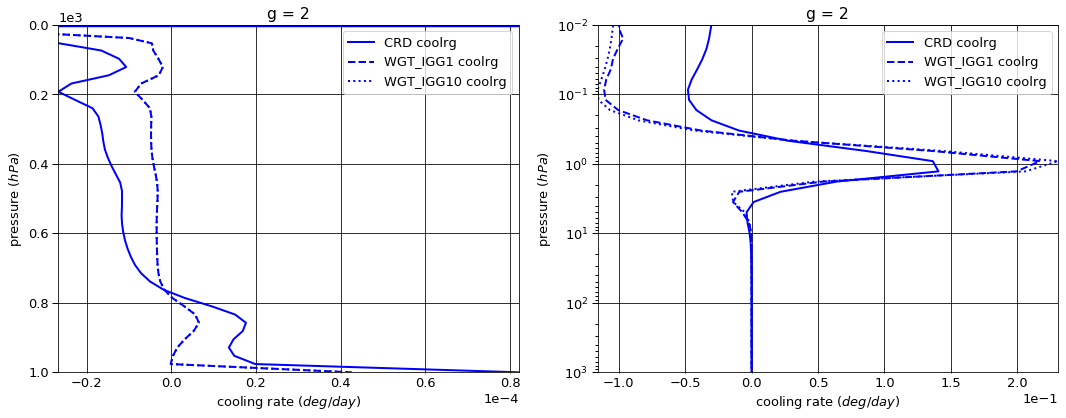

# Figure: cooling rate g-group 3

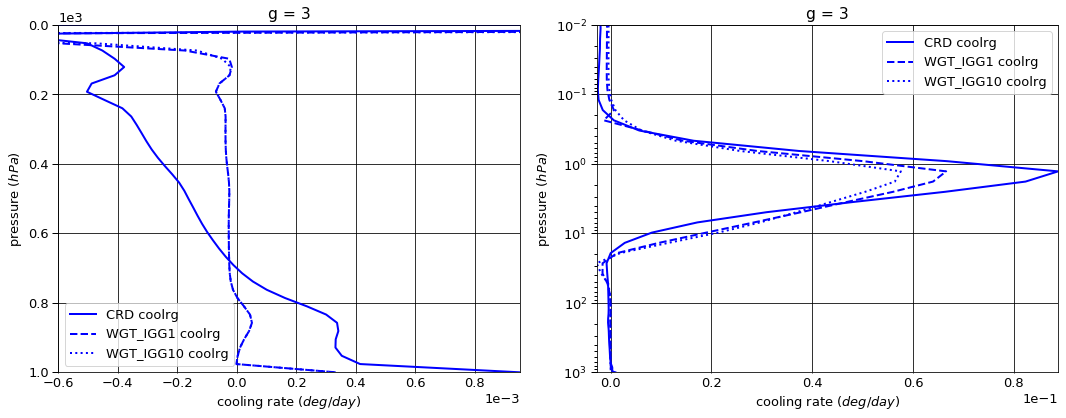

# Figure: cooling rate g-group 4

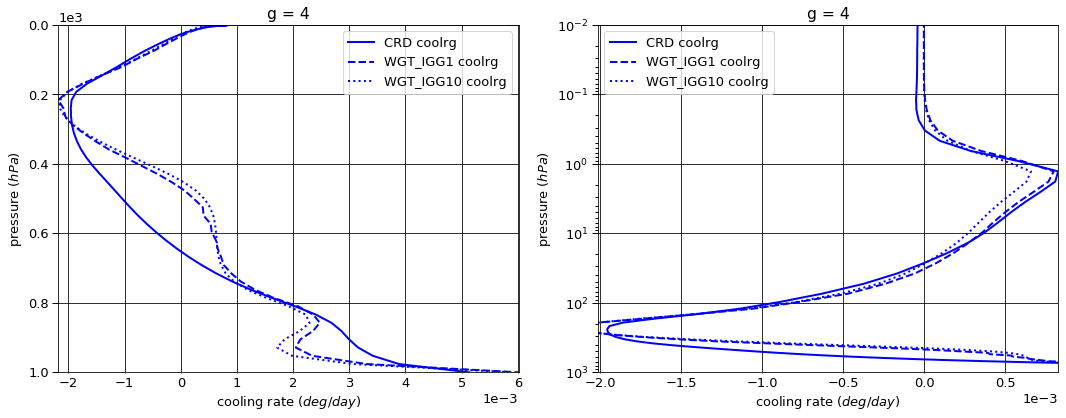

# Figure: cooling rate g-group 5

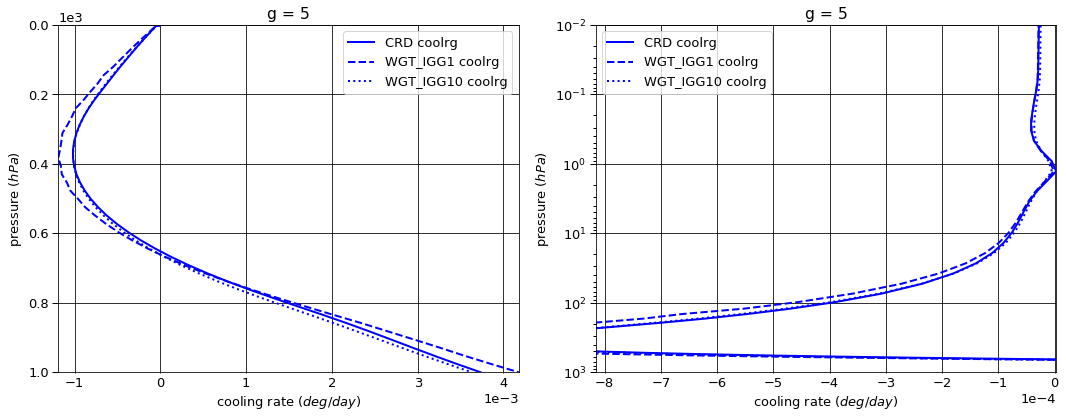

# Figure: cooling rate g-group total

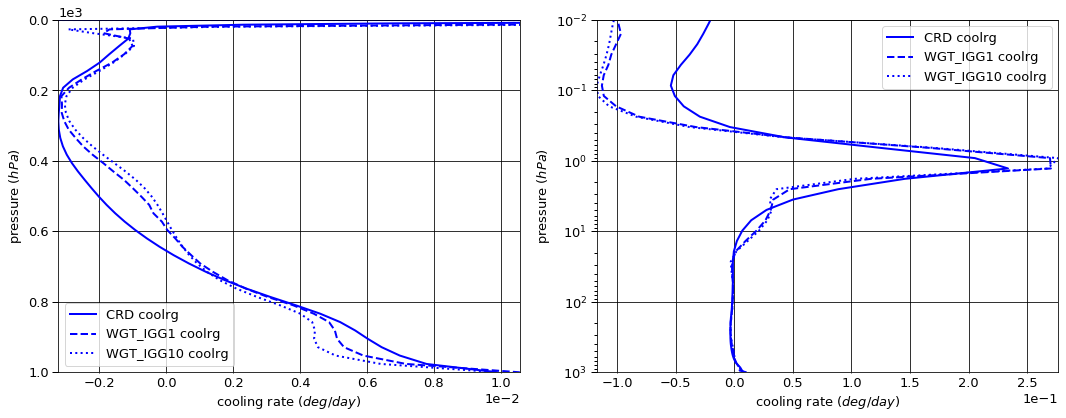

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000085  0.000000 -0.000085
  1013.0   76    -0.005713  0.005704 -0.000010
2 0.0      1     -0.017258  0.000000 -0.017258
  1013.0   76    -0.070825  0.070354 -0.000471
3 0.0      1     -0.072794  0.000000 -0.072794
  1013.0   76    -0.559384  0.518200 -0.041184
4 0.0      1     -0.294379  0.000000 -0.294379
  1013.0   76    -0.773332  0.482695 -0.290637
5 0.0      1     -5.100050  0.000000 -5.100050
  1013.0   76    -5.216198  0.144909 -5.071289


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000063  0.000000 -0.000063
  1013.0   76    -0.005713  0.005704 -0.000010
2 0.0      1     -0.017235  0.000000 -0.017235
  1013.0   76    -0.070825  0.070704 -0.000120
3 0.0      1     -0.046029  0.000000 -0.046029
  1013.0   76    -0.559384  0.558442 -0.000941
4 0.0      1     -0.068911  0.000000 -0.068911
  1013.0   76    -0.773332  0.740185 -0.033147
5 0.0      1     -5.091142  0.000000 -5.091142
  1013.0   76    -5.216198  0.151002 -5.065197


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000063  0.000000 -0.000063
  1013.0   76    -0.005713  0.005704 -0.000010
2 0.0      1     -0.017451  0.000000 -0.017451
  1013.0   76    -0.070825  0.070704 -0.000120
3 0.0      1     -0.044946  0.000000 -0.044946
  1013.0   76    -0.559384  0.558442 -0.000941
4 0.0      1     -0.061859  0.000000 -0.061859
  1013.0   76    -0.773332  0.743960 -0.029372
5 0.0      1     -5.109400  0.000000 -5.109400
  1013.0   76    -5.216198  0.129260 -5.086939


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      2.174085e-05  0.000000  2.174085e-05
  1013.0   76     0.000000e+00  0.000000  1.694066e-21
2 0.0      1      2.244800e-05  0.000000  2.244800e-05
  1013.0   76     0.000000e+00  0.000350  3.502316e-04
3 0.0      1      2.676466e-02  0.000000  2.676466e-02
  1013.0   76     0.000000e+00  0.040243  4.024257e-02
4 0.0      1      2.254673e-01  0.000000  2.254673e-01
  1013.0   76     0.000000e+00  0.257490  2.574903e-01
5 0.0      1      8.907700e-03  0.000000  8.907700e-03
  1013.0   76    -8.881784e-16  0.006093  6.092600e-03


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      2.208928e-05  0.000000  2.208928e-05
  1013.0   76     0.000000e+00  0.000000  1.694066e-21
2 0.0      1     -1.930740e-04  0.000000 -1.930740e-04
  1013.0   76     0.000000e+00  0.000350  3.502316e-04
3 0.0      1      2.784768e-02  0.000000  2.784768e-02
  1013.0   76     0.000000e+00  0.040243  4.024257e-02
4 0.0      1      2.325202e-01  0.000000  2.325202e-01
  1013.0   76     0.000000e+00  0.261265  2.612648e-01
5 0.0      1     -9.350000e-03  0.000000 -9.350000e-03
  1013.0   76    -8.881784e-16 -0.015650 -1.564960e-02

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.160670
  1001.112500 75     0.000003
2 0.000312    1     -0.029463
  1001.112500 75     0.000082
3 0.000312    1     -0.001875
  1001.112500 75     0.000952
4 0.000312    1     -0.000038
  1001.112500 75     0.005133
5 0.000312    1     -0.000026
  1001.112500 75     0.003735


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.311659
  1001.112500 75     0.000003
2 0.000312    1     -0.104540
  1001.112500 75     0.000043
3 0.000312    1     -0.000718
  1001.112500 75     0.000333
4 0.000312    1     -0.000002
  1001.112500 75     0.006012
5 0.000312    1     -0.000027
  1001.112500 75     0.004180


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.306216
  1001.112500 75     0.000003
2 0.000312    1     -0.101275
  1001.112500 75     0.000043
3 0.000312    1     -0.000428
  1001.112500 75     0.000333
4 0.000312    1     -0.000003
  1001.112500 75     0.005894
5 0.000312    1     -0.000024
  1001.112500 75     0.003632


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.509890e-01
  1001.112500 75     4.235165e-22
2 0.000312    1     -7.507690e-02
  1001.112500 75    -3.950246e-05
3 0.000312    1      1.156817e-03
  1001.112500 75    -6.187459e-04
4 0.000312    1      3.597783e-05
  1001.112500 75     8.795701e-04
5 0.000312    1     -8.256930e-07
  1001.112500 75     4.453847e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.455462e-01
  1001.112500 75     4.235165e-22
2 0.000312    1     -7.181229e-02
  1001.112500 75    -3.950246e-05
3 0.000312    1      1.446887e-03
  1001.112500 75    -6.187459e-04
4 0.000312    1      3.590194e-05
  1001.112500 75     7.611898e-04
5 0.000312    1      2.728120e-06
  1001.112500 75    -1.030049e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.484565,0.000000,-5.484565
1013.0,76,-6.625452,1.221862,-5.403591



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.223381,0.000000,-5.223381
1013.0,76,-6.625452,1.526037,-5.099415



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.233718,0.00000,-5.233718
1013.0,76,-6.625452,1.50807,-5.117383



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.611839e-01,0.000000,0.261184
1013.0,76,-8.881784e-16,0.304176,0.304176



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.508469e-01,0.000000,0.250847
1013.0,76,-8.881784e-16,0.286208,0.286208


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.129267
1001.112500,75,0.009905



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.206371
1001.112500,75,0.010571



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.204487
1001.112500,75,0.009905



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.077104
1001.112500,75,0.000667



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,7.521946e-02
1001.112500,75,-6.340700e-08


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001000,0.000728
2,0.011918,0.009146
3,0.088355,0.073974
4,0.083423,0.114834
5,0.815305,0.801318


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.062167e-18
2,1.069083e-20
3,3.732451e-23
4,6.500239e-24
5,3.693103e-32


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.062167e-18,NaN,0.001000,0.000728,0.001000,0.000728,1.0
2,1.069083e-20,3.491264e-03,0.011918,0.009146,0.012918,0.009874,1.0
3,3.732451e-23,3.491264e-03,0.088355,0.073974,0.101273,0.083848,1.0
4,6.500239e-24,1.741547e-01,0.083423,0.114834,0.184695,0.198682,50.0
5,3.693103e-32,5.681487e-09,0.815305,0.801318,1.000000,1.000000,50.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog         ratio        taulyr
layer g pressure                                                           
1     1 0.000312     8.851116e-17  4.695228e-18  1.885130e+01  3.354286e-01
      2 0.000312     8.502873e-20  6.195567e-21  1.372412e+01  2.831771e-04
      3 0.000312     1.784362e-22  1.215429e-23  1.468093e+01  5.924644e-07
      4 0.000312     6.322819e-25  3.538229e-25  1.787001e+00  2.904766e-09
      5 0.000312     4.454789e-26  8.477699e-32  5.254715e+05  2.122320e-10
2     1 0.000750     8.850578e-17  4.708627e-18  1.879652e+01  1.351067e-01
      2 0.000750     8.526460e-20  6.238792e-21  1.366685e+01  1.143986e-04
      3 0.000750     1.791960e-22  1.252000e-23  1.431277e+01  2.399206e-07
      4 0.000750     6.367584e-25  3.568211e-25  1.784531e+00  1.178600e-09
      5 0.000750     4.472313e-26  1.055689e-31  4.236391e+05  8.582051e-11
3     1 0.001052     8.849524e-17  4.736522e-18  1.868359e+01  1.894747e-01
      2 0.001052     8.573139e-20  6.287382e-21  1.363547e+01  1.613265e-04
      3 0.001052     1.803947e-22  1.280269e-23  1.409038e+01  3.389499e-07
      4 0.001052     6.444909e-25  3.613645e-25  1.783492e+00  1.673112e-09
      5 0.001052     4.509461e-26  1.153743e-31  3.908548e+05  1.213531e-10
4     1 0.001476     8.848408e-17  4.766277e-18  1.856461e+01  2.658172e-01
      2 0.001476     8.623790e-20  6.346282e-21  1.358873e+01  2.276973e-04
      3 0.001476     1.817617e-22  1.317581e-23  1.379510e+01  4.795767e-07
      4 0.001476     6.531304e-25  3.665548e-25  1.781808e+00  2.379095e-09
      5 0.001476     4.549538e-26  1.265027e-31  3.596396e+05  1.717584e-10
5     1 0.002070     8.847284e-17  4.796351e-18  1.844586e+01  3.728385e-01
      2 0.002070     8.676146e-20  6.419893e-21  1.351447e+01  3.213867e-04
      3 0.002070     1.832754e-22  1.366389e-23  1.341312e+01  6.791401e-07
      4 0.002070     6.624414e-25  3.723400e-25  1.779130e+00  3.385446e-09
      5 0.002070     4.590487e-26  1.368053e-31  3.355488e+05  2.430744e-10
6     1 0.002904     8.846145e-17  4.826784e-18  1.832720e+01  5.230041e-01
      2 0.002904     8.730586e-20  6.509903e-21  1.341124e+01  4.538141e-04
      3 0.002904     1.849833e-22  1.429935e-23  1.293648e+01  9.632108e-07
      4 0.002904     6.726327e-25  3.789251e-25  1.775107e+00  4.824074e-09
      5 0.002904     4.632339e-26  1.467593e-31  3.156418e+05  3.440782e-10
7     1 0.004074     8.844978e-17  4.857670e-18  1.820827e+01  7.336690e-01
      2 0.004074     8.787697e-20  6.620928e-21  1.327261e+01  6.410796e-04
      3 0.004074     1.869538e-22  1.512046e-23  1.236430e+01  1.368656e-06
      4 0.004074     6.840073e-25  3.866132e-25  1.769229e+00  6.885964e-09
      5 0.004074     4.675184e-26  1.560356e-31  2.996228e+05  4.871281e-10
8     1 0.005714     8.843767e-17  4.889141e-18  1.808859e+01  1.029119e+00
      2 0.005714     8.848300e-20  6.758695e-21  1.309173e+01  9.060294e-04
      3 0.005714     1.892824e-22  1.616854e-23  1.170684e+01  1.949284e-06
      4 0.005714     6.969900e-25  3.958274e-25  1.760843e+00  9.851273e-09
      5 0.005714     4.719146e-26  1.641551e-31  2.874808e+05  6.897100e-10
9     1 0.008015     8.842489e-17  4.921385e-18  1.796748e+01  1.443576e+00
      2 0.008015     8.913554e-20  6.929699e-21  1.286283e+01  1.281377e-03
      3 0.008015     1.921035e-22  1.748571e-23  1.098632e+01  2.784847e-06
      4 0.008015     7.121793e-25  4.071590e-25  1.749143e+00  1.413816e-08
      5 0.008015     4.764397e-26  1.709350e-31  2.787257e+05  9.767433e-10
10    1 0.011243     8.841113e-17  4.954654e-18  1.784406e+01  2.024908e+00
      2 0.011243     8.985058e-20  7.141086e-21  1.258220e+01  1.813791e-03
      3 0.011243     1.956052e-22  1.911352e-23  1.023387e+01  3.994225e-06
      4 0.011243     7.304132e-25  4.214275e-25  1.733188e+00  2.037611e-08
      5 0.011243     4.811160e-26  1.766122e-31  2.724139e+05  1.383520e-09
11    1 0.015771     8.839593e-17  4.989295e-18  1.771712e+01  2.840362e+0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
